# Method 5 - Rest Ideas After 15

In [1]:
%matplotlib inline
import pandas as pd
import warnings
from statsmodels import api as sm

from eptooling import crsp, epd, fs, hfu, crsp, db, bi
from eptooling.bm import bmdb, iso
from epquant.engine import weights, portfolio
from epquant.gen import returns
from epquant.perf import relative_performance

warnings.filterwarnings("ignore")

## Fetch Holdings and Benchmark Data

In [2]:
# Get HFU Data

%store -r inst_data
inst_data = inst_data[inst_data['datadate'] >= '1999-06-30']

# Count number of positions per manager

inst_data['num_pos'] = inst_data.groupby(['datadate', 'institution_id'])[
    'fsym_id'].transform(lambda s: s.nunique())

# Remove less than 20 holdings and less than $5mm per CSP

valid_data = inst_data[inst_data['num_pos'] >= 20]
valid_data = valid_data[valid_data['public_aum'] >= 5e6]

# Add Expected Returns per Shumway, Szefler, Yuan 2009

%store -r exp_ret

valid_data = valid_data.merge(exp_ret, on=['datadate', 'institution_id', 'fsym_id'], how='left')

# Calculate CSP Weight per Market Tilt

valid_data['adj_target'] = valid_data['expected_return']

## Calculate Rest Ideas

In [3]:
# Extract Rest Ideas

valid_data['pos_rank'] = valid_data\
    .groupby(['datadate', 'institution_id'])['adj_target'].rank(ascending=False)

best_ideas = valid_data[valid_data['pos_rank'] > 15].copy()

# Weight the best ideas

best_ideas['target'] = best_ideas['target'] / best_ideas.groupby([
    'datadate', 'institution_id'])['target'].transform('sum') * \
                        (1 / best_ideas.groupby('datadate')['institution_id']
                         .transform(lambda s: s.nunique()))

## Backtest Portfolio

In [4]:
w = weights.Weights(best_ideas)

%store -r r

p = portfolio.DailyPortfolio(w, r, end_date='2018-12-31')

rf = bi.get_risk_free_rate()
monthly_return = p.port_return.loc['1999-07-01':].resample('M').apply(epd.prod_red)
monthly_return = (monthly_return - rf).dropna()
monthly_return.name = 'port_return'

## Plot Performance

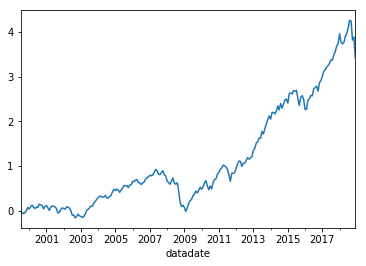

In [5]:
epd.nav(monthly_return).plot()

In [6]:
monthly_return.resample('A').apply(epd.prod_red)

datadate
1999-12-31    0.068201
2000-12-31    0.020456
2001-12-31   -0.027557
2002-12-31   -0.167658
2003-12-31    0.415054
2004-12-31    0.184761
2005-12-31    0.067549
2006-12-31    0.111852
2007-12-31    0.014004
2008-12-31   -0.370026
2009-12-31    0.356401
2010-12-31    0.192369
2011-12-31    0.018019
2012-12-31    0.195497
2013-12-31    0.412298
2014-12-31    0.121525
2015-12-31   -0.002322
2016-12-31    0.121920
2017-12-31    0.209404
2018-12-31   -0.067825
Freq: A-DEC, Name: port_return, dtype: float64

## Fetch Factor Models

In [7]:
# Get Factor Models
q_factor_model = bi.get_q_factor_model()
fama_french_five_factor_model = bi.get_fama_french_five_factor_model()
four_factor_model = bi.get_four_factor_model()

# Concat Portfolio Return
q_factor = pd.concat([monthly_return, q_factor_model], axis=1)
fama_french_five = pd.concat([monthly_return, fama_french_five_factor_model], axis=1)
four_factor = pd.concat([monthly_return, four_factor_model], axis=1)

# Add Constants
q_factor.insert(1, 'const', 1)
fama_french_five.insert(1, 'const', 1)
four_factor.insert(1, 'const', 1)

# Split Period into Pre and Post Crisis
q_factor_pre, q_factor_post = q_factor.loc[:'2009-06-30'], q_factor.loc['2009-07-31':]
fama_french_five_pre, fama_french_five_post = fama_french_five.loc[:'2009-06-30'], fama_french_five.loc['2009-07-31':] 
four_factor_pre, four_factor_post = four_factor.loc[:'2009-06-30'], four_factor.loc['2009-07-31':] 

## Full Time Period Regressions

### Q Factor Model

In [8]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.968
Model:                            OLS   Adj. R-squared:                  0.968
Method:                 Least Squares   F-statistic:                     1751.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          2.24e-170
Time:                        04:51:17   Log-Likelihood:                 817.57
No. Observations:                 234   AIC:                            -1625.
Df Residuals:                     229   BIC:                            -1608.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0022      0.001      4.358      0.000       0.001       0.003
mktrf          0.9211      0.014     66.454      0.000       0.894       0.948
me             0.2080      0.016     12.904      0.000       0.176       0.240
ia             0.1242      0.025      5.067      0.000       0.076       0.172
roe            0.0774      0.021      3.692      0.000       0.036       0.119
==============================================================================
Omnibus:                        8.991   Durbin-Watson:                   1.758
Prob(Omnibus):                  0.011   Jarque-Bera (JB):               17.393
Skew:                           0.028   Prob(JB):                     0.000167
Kurtosis:                       4.334   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [9]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.968
Model:                            OLS   Adj. R-squared:                  0.968
Method:                 Least Squares   F-statistic:                     915.1
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          1.57e-139
Time:                        04:51:17   Log-Likelihood:                 817.57
No. Observations:                 234   AIC:                            -1625.
Df Residuals:                     229   BIC:                            -1608.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0022      0.001      3.975      0.000       0.001       0.003
mktrf          0.9211      0.018     50.760      0.000       0.885       0.957
me             0.2080      0.036      5.775      0.000       0.137       0.279
ia             0.1242      0.052      2.388      0.017       0.022       0.226
roe            0.0774      0.021      3.760      0.000       0.037       0.118
==============================================================================
Omnibus:                        8.991   Durbin-Watson:                   1.758
Prob(Omnibus):                  0.011   Jarque-Bera (JB):               17.393
Skew:                           0.028   Prob(JB):                     0.000167
Kurtosis:                       4.334   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [10]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.968
Model:                            OLS   Adj. R-squared:                  0.968
Method:                 Least Squares   F-statistic:                     1153.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          2.14e-150
Time:                        04:51:17   Log-Likelihood:                 817.57
No. Observations:                 234   AIC:                            -1625.
Df Residuals:                     229   BIC:                            -1608.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0022      0.001      4.150      0.000       0.001       0.003
mktrf          0.9211      0.016     56.550      0.000       0.889       0.953
me             0.2080      0.034      6.066      0.000       0.141       0.275
ia             0.1242      0.060      2.074      0.038       0.007       0.241
roe            0.0774      0.020      3.814      0.000       0.038       0.117
==============================================================================
Omnibus:                        8.991   Durbin-Watson:                   1.758
Prob(Omnibus):                  0.011   Jarque-Bera (JB):               17.393
Skew:                           0.028   Prob(JB):                     0.000167
Kurtosis:                       4.334   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [11]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.968
Model:                            OLS   Adj. R-squared:                  0.967
Method:                 Least Squares   F-statistic:                     1375.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          4.85e-168
Time:                        04:51:17   Log-Likelihood:                 815.95
No. Observations:                 234   AIC:                            -1620.
Df Residuals:                     228   BIC:                            -1599.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0018      0.001      3.456      0.001       0.001       0.003
mktrf          0.9329      0.014     66.568      0.000       0.905       0.961
smb            0.2434      0.018     13.164      0.000       0.207       0.280
hml           -0.0005      0.022     -0.021      0.983      -0.043       0.043
rmw            0.1234      0.025      5.005      0.000       0.075       0.172
cma            0.1027      0.031      3.278      0.001       0.041       0.164
==============================================================================
Omnibus:                       17.534   Durbin-Watson:                   1.662
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               56.466
Skew:                          -0.063   Prob(JB):                     5.48e-13
Kurtosis:                       5.403   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [12]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.968
Model:                            OLS   Adj. R-squared:                  0.967
Method:                 Least Squares   F-statistic:                     644.8
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          2.46e-132
Time:                        04:51:17   Log-Likelihood:                 815.95
No. Observations:                 234   AIC:                            -1620.
Df Residuals:                     228   BIC:                            -1599.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0018      0.001      3.136      0.002       0.001       0.003
mktrf          0.9329      0.023     41.240      0.000       0.889       0.977
smb            0.2434      0.028      8.776      0.000       0.189       0.298
hml           -0.0005      0.049     -0.009      0.993      -0.096       0.095
rmw            0.1234      0.025      4.991      0.000       0.075       0.172
cma            0.1027      0.054      1.905      0.057      -0.003       0.208
==============================================================================
Omnibus:                       17.534   Durbin-Watson:                   1.662
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               56.466
Skew:                          -0.063   Prob(JB):                     5.48e-13
Kurtosis:                       5.403   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [13]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.968
Model:                            OLS   Adj. R-squared:                  0.967
Method:                 Least Squares   F-statistic:                     871.7
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          2.14e-146
Time:                        04:51:17   Log-Likelihood:                 815.95
No. Observations:                 234   AIC:                            -1620.
Df Residuals:                     228   BIC:                            -1599.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0018      0.001      3.156      0.002       0.001       0.003
mktrf          0.9329      0.022     42.732      0.000       0.890       0.976
smb            0.2434      0.027      8.889      0.000       0.190       0.297
hml           -0.0005      0.055     -0.008      0.993      -0.109       0.108
rmw            0.1234      0.024      5.057      0.000       0.076       0.171
cma            0.1027      0.051      2.015      0.044       0.003       0.203
==============================================================================
Omnibus:                       17.534   Durbin-Watson:                   1.662
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               56.466
Skew:                          -0.063   Prob(JB):                     5.48e-13
Kurtosis:                       5.403   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [14]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.961
Model:                            OLS   Adj. R-squared:                  0.960
Method:                 Least Squares   F-statistic:                     1410.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          5.42e-160
Time:                        04:51:17   Log-Likelihood:                 793.13
No. Observations:                 234   AIC:                            -1576.
Df Residuals:                     229   BIC:                            -1559.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0026      0.001      4.722      0.000       0.002       0.004
mktrf          0.9027      0.014     63.723      0.000       0.875       0.931
smb            0.1789      0.018     10.119      0.000       0.144       0.214
hml            0.1278      0.018      7.277      0.000       0.093       0.162
umd            0.0250      0.012      2.173      0.031       0.002       0.048
==============================================================================
Omnibus:                       21.611   Durbin-Watson:                   1.634
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               84.134
Skew:                           0.108   Prob(JB):                     5.38e-19
Kurtosis:                       5.930   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [15]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.961
Model:                            OLS   Adj. R-squared:                  0.960
Method:                 Least Squares   F-statistic:                     763.8
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          4.00e-131
Time:                        04:51:17   Log-Likelihood:                 793.13
No. Observations:                 234   AIC:                            -1576.
Df Residuals:                     229   BIC:                            -1559.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0026      0.001      4.011      0.000       0.001       0.004
mktrf          0.9027      0.021     42.829      0.000       0.861       0.944
smb            0.1789      0.034      5.230      0.000       0.112       0.246
hml            0.1278      0.058      2.199      0.028       0.014       0.242
umd            0.0250      0.019      1.310      0.190      -0.012       0.063
==============================================================================
Omnibus:                       21.611   Durbin-Watson:                   1.634
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               84.134
Skew:                           0.108   Prob(JB):                     5.38e-19
Kurtosis:                       5.930   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [16]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.961
Model:                            OLS   Adj. R-squared:                  0.960
Method:                 Least Squares   F-statistic:                     924.6
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          5.15e-140
Time:                        04:51:17   Log-Likelihood:                 793.13
No. Observations:                 234   AIC:                            -1576.
Df Residuals:                     229   BIC:                            -1559.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0026      0.001      4.224      0.000       0.001       0.004
mktrf          0.9027      0.020     44.979      0.000       0.863       0.942
smb            0.1789      0.036      4.992      0.000       0.109       0.249
hml            0.1278      0.069      1.863      0.062      -0.007       0.262
umd            0.0250      0.015      1.640      0.101      -0.005       0.055
==============================================================================
Omnibus:                       21.611   Durbin-Watson:                   1.634
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               84.134
Skew:                           0.108   Prob(JB):                     5.38e-19
Kurtosis:                       5.930   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Pre-Crisis Regressions

### Q Factor Model

In [17]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.964
Model:                            OLS   Adj. R-squared:                  0.962
Method:                 Least Squares   F-statistic:                     763.8
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           8.48e-82
Time:                        04:51:17   Log-Likelihood:                 401.12
No. Observations:                 120   AIC:                            -792.2
Df Residuals:                     115   BIC:                            -778.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0021      0.001      2.524      0.013       0.000       0.004
mktrf          0.9293      0.023     41.272      0.000       0.885       0.974
me             0.2030      0.022      9.129      0.000       0.159       0.247
ia             0.1807      0.035      5.189      0.000       0.112       0.250
roe            0.0823      0.031      2.671      0.009       0.021       0.143
==============================================================================
Omnibus:                        4.033   Durbin-Watson:                   1.706
Prob(Omnibus):                  0.133   Jarque-Bera (JB):                5.014
Skew:                           0.009   Prob(JB):                       0.0815
Kurtosis:                       4.001   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [18]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.964
Model:                            OLS   Adj. R-squared:                  0.962
Method:                 Least Squares   F-statistic:                     429.1
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           4.16e-68
Time:                        04:51:17   Log-Likelihood:                 401.12
No. Observations:                 120   AIC:                            -792.2
Df Residuals:                     115   BIC:                            -778.3
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0021      0.001      2.193      0.028       0.000       0.004
mktrf          0.9293      0.027     34.612      0.000       0.877       0.982
me             0.2030      0.040      5.062      0.000       0.124       0.282
ia             0.1807      0.053      3.399      0.001       0.077       0.285
roe            0.0823      0.021      4.012      0.000       0.042       0.123
==============================================================================
Omnibus:                        4.033   Durbin-Watson:                   1.706
Prob(Omnibus):                  0.133   Jarque-Bera (JB):                5.014
Skew:                           0.009   Prob(JB):                       0.0815
Kurtosis:                       4.001   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [19]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.964
Model:                            OLS   Adj. R-squared:                  0.962
Method:                 Least Squares   F-statistic:                     751.5
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.09e-81
Time:                        04:51:17   Log-Likelihood:                 401.12
No. Observations:                 120   AIC:                            -792.2
Df Residuals:                     115   BIC:                            -778.3
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0021      0.001      2.321      0.020       0.000       0.004
mktrf          0.9293      0.021     44.466      0.000       0.888       0.970
me             0.2030      0.039      5.155      0.000       0.126       0.280
ia             0.1807      0.056      3.231      0.001       0.071       0.290
roe            0.0823      0.017      4.927      0.000       0.050       0.115
==============================================================================
Omnibus:                        4.033   Durbin-Watson:                   1.706
Prob(Omnibus):                  0.133   Jarque-Bera (JB):                5.014
Skew:                           0.009   Prob(JB):                       0.0815
Kurtosis:                       4.001   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [20]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.962
Model:                            OLS   Adj. R-squared:                  0.960
Method:                 Least Squares   F-statistic:                     574.0
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           4.79e-79
Time:                        04:51:17   Log-Likelihood:                 398.01
No. Observations:                 120   AIC:                            -784.0
Df Residuals:                     114   BIC:                            -767.3
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0020      0.001      2.251      0.026       0.000       0.004
mktrf          0.9617      0.024     39.296      0.000       0.913       1.010
smb            0.2558      0.028      9.227      0.000       0.201       0.311
hml            0.0048      0.034      0.141      0.888      -0.062       0.072
rmw            0.1469      0.040      3.669      0.000       0.068       0.226
cma            0.1525      0.044      3.477      0.001       0.066       0.239
==============================================================================
Omnibus:                       10.592   Durbin-Watson:                   1.668
Prob(Omnibus):                  0.005   Jarque-Bera (JB):               27.268
Skew:                          -0.020   Prob(JB):                     1.20e-06
Kurtosis:                       5.335   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [21]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.962
Model:                            OLS   Adj. R-squared:                  0.960
Method:                 Least Squares   F-statistic:                     408.4
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           5.17e-71
Time:                        04:51:18   Log-Likelihood:                 398.01
No. Observations:                 120   AIC:                            -784.0
Df Residuals:                     114   BIC:                            -767.3
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0020      0.001      2.028      0.043    6.69e-05       0.004
mktrf          0.9617      0.041     23.251      0.000       0.881       1.043
smb            0.2558      0.040      6.472      0.000       0.178       0.333
hml            0.0048      0.084      0.057      0.955      -0.160       0.170
rmw            0.1469      0.055      2.681      0.007       0.040       0.254
cma            0.1525      0.073      2.098      0.036       0.010       0.295
==============================================================================
Omnibus:                       10.592   Durbin-Watson:                   1.668
Prob(Omnibus):                  0.005   Jarque-Bera (JB):               27.268
Skew:                          -0.020   Prob(JB):                     1.20e-06
Kurtosis:                       5.335   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [22]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.962
Model:                            OLS   Adj. R-squared:                  0.960
Method:                 Least Squares   F-statistic:                     778.6
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.45e-86
Time:                        04:51:18   Log-Likelihood:                 398.01
No. Observations:                 120   AIC:                            -784.0
Df Residuals:                     114   BIC:                            -767.3
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0020      0.001      2.277      0.023       0.000       0.004
mktrf          0.9617      0.039     24.608      0.000       0.885       1.038
smb            0.2558      0.038      6.674      0.000       0.181       0.331
hml            0.0048      0.096      0.050      0.960      -0.183       0.192
rmw            0.1469      0.057      2.571      0.010       0.035       0.259
cma            0.1525      0.073      2.097      0.036       0.010       0.295
==============================================================================
Omnibus:                       10.592   Durbin-Watson:                   1.668
Prob(Omnibus):                  0.005   Jarque-Bera (JB):               27.268
Skew:                          -0.020   Prob(JB):                     1.20e-06
Kurtosis:                       5.335   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [23]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.952
Model:                            OLS   Adj. R-squared:                  0.951
Method:                 Least Squares   F-statistic:                     575.6
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           4.94e-75
Time:                        04:51:18   Log-Likelihood:                 384.85
No. Observations:                 120   AIC:                            -759.7
Df Residuals:                     115   BIC:                            -745.8
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0032      0.001      3.405      0.001       0.001       0.005
mktrf          0.9022      0.023     39.717      0.000       0.857       0.947
smb            0.1850      0.026      7.151      0.000       0.134       0.236
hml            0.1765      0.026      6.813      0.000       0.125       0.228
umd            0.0226      0.016      1.414      0.160      -0.009       0.054
==============================================================================
Omnibus:                       15.020   Durbin-Watson:                   1.616
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               54.988
Skew:                           0.093   Prob(JB):                     1.15e-12
Kurtosis:                       6.311   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [24]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.952
Model:                            OLS   Adj. R-squared:                  0.951
Method:                 Least Squares   F-statistic:                     497.6
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.39e-71
Time:                        04:51:18   Log-Likelihood:                 384.85
No. Observations:                 120   AIC:                            -759.7
Df Residuals:                     115   BIC:                            -745.8
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0032      0.001      3.119      0.002       0.001       0.005
mktrf          0.9022      0.033     27.199      0.000       0.837       0.967
smb            0.1850      0.040      4.592      0.000       0.106       0.264
hml            0.1765      0.071      2.483      0.013       0.037       0.316
umd            0.0226      0.021      1.068      0.286      -0.019       0.064
==============================================================================
Omnibus:                       15.020   Durbin-Watson:                   1.616
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               54.988
Skew:                           0.093   Prob(JB):                     1.15e-12
Kurtosis:                       6.311   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [25]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.952
Model:                            OLS   Adj. R-squared:                  0.951
Method:                 Least Squares   F-statistic:                     784.2
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.97e-82
Time:                        04:51:18   Log-Likelihood:                 384.85
No. Observations:                 120   AIC:                            -759.7
Df Residuals:                     115   BIC:                            -745.8
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0032      0.001      3.550      0.000       0.001       0.005
mktrf          0.9022      0.028     32.359      0.000       0.848       0.957
smb            0.1850      0.044      4.234      0.000       0.099       0.271
hml            0.1765      0.080      2.219      0.026       0.021       0.332
umd            0.0226      0.018      1.280      0.200      -0.012       0.057
==============================================================================
Omnibus:                       15.020   Durbin-Watson:                   1.616
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               54.988
Skew:                           0.093   Prob(JB):                     1.15e-12
Kurtosis:                       6.311   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Post-Crisis Regressions

### Q Factor Model

In [26]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.982
Model:                            OLS   Adj. R-squared:                  0.982
Method:                 Least Squares   F-statistic:                     1507.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.13e-94
Time:                        04:51:18   Log-Likelihood:                 445.00
No. Observations:                 114   AIC:                            -880.0
Df Residuals:                     109   BIC:                            -866.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0024      0.000      4.799      0.000       0.001       0.003
mktrf          0.9177      0.015     62.535      0.000       0.889       0.947
me             0.2193      0.023      9.677      0.000       0.174       0.264
ia            -0.0486      0.031     -1.547      0.125      -0.111       0.014
roe            0.0069      0.028      0.250      0.803      -0.048       0.062
==============================================================================
Omnibus:                        0.459   Durbin-Watson:                   1.746
Prob(Omnibus):                  0.795   Jarque-Bera (JB):                0.611
Skew:                           0.112   Prob(JB):                        0.737
Kurtosis:                       2.720   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [27]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.982
Model:                            OLS   Adj. R-squared:                  0.982
Method:                 Least Squares   F-statistic:                     1240.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           7.24e-90
Time:                        04:51:18   Log-Likelihood:                 445.00
No. Observations:                 114   AIC:                            -880.0
Df Residuals:                     109   BIC:                            -866.3
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0024      0.001      4.288      0.000       0.001       0.003
mktrf          0.9177      0.016     58.696      0.000       0.887       0.948
me             0.2193      0.029      7.496      0.000       0.162       0.277
ia            -0.0486      0.035     -1.396      0.163      -0.117       0.020
roe            0.0069      0.029      0.237      0.813      -0.050       0.064
==============================================================================
Omnibus:                        0.459   Durbin-Watson:                   1.746
Prob(Omnibus):                  0.795   Jarque-Bera (JB):                0.611
Skew:                           0.112   Prob(JB):                        0.737
Kurtosis:                       2.720   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [28]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.982
Model:                            OLS   Adj. R-squared:                  0.982
Method:                 Least Squares   F-statistic:                     1197.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           4.79e-89
Time:                        04:51:18   Log-Likelihood:                 445.00
No. Observations:                 114   AIC:                            -880.0
Df Residuals:                     109   BIC:                            -866.3
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0024      0.001      3.697      0.000       0.001       0.004
mktrf          0.9177      0.015     59.481      0.000       0.887       0.948
me             0.2193      0.033      6.720      0.000       0.155       0.283
ia            -0.0486      0.040     -1.218      0.223      -0.127       0.030
roe            0.0069      0.025      0.275      0.783      -0.042       0.056
==============================================================================
Omnibus:                        0.459   Durbin-Watson:                   1.746
Prob(Omnibus):                  0.795   Jarque-Bera (JB):                0.611
Skew:                           0.112   Prob(JB):                        0.737
Kurtosis:                       2.720   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [29]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.988
Model:                            OLS   Adj. R-squared:                  0.988
Method:                 Least Squares   F-statistic:                     1808.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          2.34e-102
Time:                        04:51:18   Log-Likelihood:                 468.29
No. Observations:                 114   AIC:                            -924.6
Df Residuals:                     108   BIC:                            -908.2
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0015      0.000      3.775      0.000       0.001       0.002
mktrf          0.9208      0.011     80.334      0.000       0.898       0.944
smb            0.2111      0.019     11.346      0.000       0.174       0.248
hml           -0.0722      0.024     -3.041      0.003      -0.119      -0.025
rmw           -0.0419      0.029     -1.443      0.152      -0.100       0.016
cma            0.0040      0.037      0.108      0.914      -0.069       0.077
==============================================================================
Omnibus:                        3.442   Durbin-Watson:                   1.659
Prob(Omnibus):                  0.179   Jarque-Bera (JB):                3.076
Skew:                          -0.237   Prob(JB):                        0.215
Kurtosis:                       3.650   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [30]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.988
Model:                            OLS   Adj. R-squared:                  0.988
Method:                 Least Squares   F-statistic:                     2967.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          7.41e-114
Time:                        04:51:18   Log-Likelihood:                 468.29
No. Observations:                 114   AIC:                            -924.6
Df Residuals:                     108   BIC:                            -908.2
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0015      0.000      3.320      0.001       0.001       0.002
mktrf          0.9208      0.012     78.725      0.000       0.898       0.944
smb            0.2111      0.023      9.013      0.000       0.165       0.257
hml           -0.0722      0.024     -2.991      0.003      -0.119      -0.025
rmw           -0.0419      0.022     -1.937      0.053      -0.084       0.001
cma            0.0040      0.048      0.083      0.934      -0.090       0.098
==============================================================================
Omnibus:                        3.442   Durbin-Watson:                   1.659
Prob(Omnibus):                  0.179   Jarque-Bera (JB):                3.076
Skew:                          -0.237   Prob(JB):                        0.215
Kurtosis:                       3.650   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [31]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.988
Model:                            OLS   Adj. R-squared:                  0.988
Method:                 Least Squares   F-statistic:                     5240.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          4.04e-127
Time:                        04:51:18   Log-Likelihood:                 468.29
No. Observations:                 114   AIC:                            -924.6
Df Residuals:                     108   BIC:                            -908.2
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0015      0.001      2.760      0.006       0.000       0.003
mktrf          0.9208      0.011     82.224      0.000       0.899       0.943
smb            0.2111      0.022      9.405      0.000       0.167       0.255
hml           -0.0722      0.023     -3.132      0.002      -0.117      -0.027
rmw           -0.0419      0.023     -1.829      0.067      -0.087       0.003
cma            0.0040      0.051      0.079      0.937      -0.095       0.103
==============================================================================
Omnibus:                        3.442   Durbin-Watson:                   1.659
Prob(Omnibus):                  0.179   Jarque-Bera (JB):                3.076
Skew:                          -0.237   Prob(JB):                        0.215
Kurtosis:                       3.650   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [32]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.988
Model:                            OLS   Adj. R-squared:                  0.987
Method:                 Least Squares   F-statistic:                     2191.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          4.09e-103
Time:                        04:51:18   Log-Likelihood:                 466.00
No. Observations:                 114   AIC:                            -922.0
Df Residuals:                     109   BIC:                            -908.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0014      0.000      3.490      0.001       0.001       0.002
mktrf          0.9252      0.012     79.986      0.000       0.902       0.948
smb            0.2199      0.018     12.192      0.000       0.184       0.256
hml           -0.0440      0.019     -2.369      0.020      -0.081      -0.007
umd           -0.0008      0.014     -0.056      0.956      -0.029       0.027
==============================================================================
Omnibus:                        4.497   Durbin-Watson:                   1.588
Prob(Omnibus):                  0.106   Jarque-Bera (JB):                4.725
Skew:                          -0.238   Prob(JB):                       0.0942
Kurtosis:                       3.876   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [33]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.988
Model:                            OLS   Adj. R-squared:                  0.987
Method:                 Least Squares   F-statistic:                     3040.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          8.66e-111
Time:                        04:51:18   Log-Likelihood:                 466.00
No. Observations:                 114   AIC:                            -922.0
Df Residuals:                     109   BIC:                            -908.3
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0014      0.000      3.165      0.002       0.001       0.002
mktrf          0.9252      0.012     77.027      0.000       0.902       0.949
smb            0.2199      0.022      9.844      0.000       0.176       0.264
hml           -0.0440      0.014     -3.131      0.002      -0.072      -0.016
umd           -0.0008      0.012     -0.067      0.947      -0.024       0.022
==============================================================================
Omnibus:                        4.497   Durbin-Watson:                   1.588
Prob(Omnibus):                  0.106   Jarque-Bera (JB):                4.725
Skew:                          -0.238   Prob(JB):                       0.0942
Kurtosis:                       3.876   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [34]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.988
Model:                            OLS   Adj. R-squared:                  0.987
Method:                 Least Squares   F-statistic:                     4932.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          3.70e-122
Time:                        04:51:18   Log-Likelihood:                 466.00
No. Observations:                 114   AIC:                            -922.0
Df Residuals:                     109   BIC:                            -908.3
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0014      0.001      2.690      0.007       0.000       0.002
mktrf          0.9252      0.011     80.496      0.000       0.903       0.948
smb            0.2199      0.021     10.364      0.000       0.178       0.261
hml           -0.0440      0.015     -2.971      0.003      -0.073      -0.015
umd           -0.0008      0.013     -0.059      0.953      -0.027       0.025
==============================================================================
Omnibus:                        4.497   Durbin-Watson:                   1.588
Prob(Omnibus):                  0.106   Jarque-Bera (JB):                4.725
Skew:                          -0.238   Prob(JB):                       0.0942
Kurtosis:                       3.876   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""